# THE EMBER HOUSE 

Este notebook possui o intuito de fazer o estudo de aprendizado de máquina sobre os diferentes tipos de grãos de cafés disponíveis no dataset coffee-bean-dataset-resized, que possui um conjunto de 4800 imagens de 4 tipos de torras. Com o modelo obtido, será possível realizar a identificação automática de tipos de grãos de café e por qual tipo de torra aos quais foram submetidos.  

In [63]:
# carregando bibliotecas utilizadas
import kagglehub
import pandas as pd
import shutil
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

In [64]:
# Carregando dados caso ainda não importados

data_dir = "data"

if len(os.listdir(data_dir)) == 1: #Caso exista apenas o gitkeep, realiza o download do dataset
    path = kagglehub.dataset_download("gpiosenka/coffee-bean-dataset-resized-224-x-224")    
    for item in os.listdir(path):
        shutil.move(os.path.join(path, item), data_dir)
    os.rmdir(path) # Apgara o diretório de download utilizado pelo pacote kaggle       

      

In [65]:
# Load e correções em dados

coffee_info = pd.read_csv("data/Coffee Bean.csv")
coffee_info["filepaths"] = "data/"+coffee_info["filepaths"] #Ajustando o caminho das imagens conforme estrutura de diretórios criada no projeto



## Análise exploratória:

In [66]:
# Visualização dos dados
coffee_info.head()

,class index,filepaths,labels,data set
0,0,data/train/Dark/dark (1).png,Dark,train
1,0,data/train/Dark/dark (10).png,Dark,train
2,0,data/train/Dark/dark (100).png,Dark,train
3,0,data/train/Dark/dark (101).png,Dark,train
4,0,data/train/Dark/dark (102).png,Dark,train


In [67]:
# Verificação de duplicatas

duplicated_files = coffee_info["filepaths"].duplicated().sum()
print("Número de arquivos duplicados:", duplicated_files)

Número de arquivos duplicados: 0


In [68]:
#Comprimento médio dos nomes dos arquivos
coffee_info["filepath_length"] = coffee_info["filepaths"].apply(len)
avg_length = coffee_info["filepath_length"].mean()
print("Comprimento médio dos nomes de arquivos:", avg_length)

Comprimento médio dos nomes de arquivos: 31.21


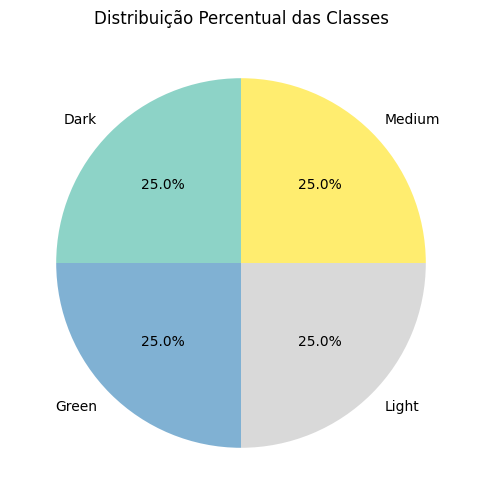

In [69]:
#Distribuição percentual das classes

plt.figure(figsize=(6,6))
coffee_info["labels"].value_counts().plot(kind="pie", autopct="%.1f%%", startangle=90, cmap="Set3")
plt.title("Distribuição Percentual das Classes")
plt.ylabel("")
plt.show()

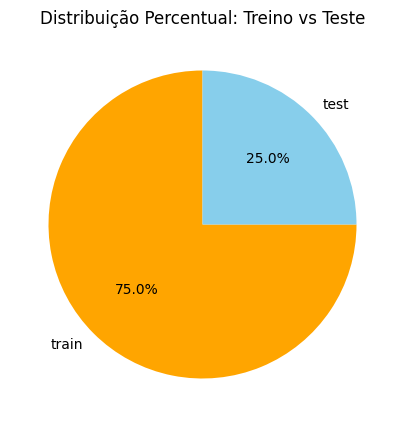

In [70]:
#Distribuição percentual do treino vs teste

plt.figure(figsize=(5,5))
coffee_info["data set"].value_counts().plot(kind="pie", autopct="%.1f%%", startangle=90, colors=["orange", "skyblue"])
plt.title("Distribuição Percentual: Treino vs Teste")
plt.ylabel("")
plt.show()

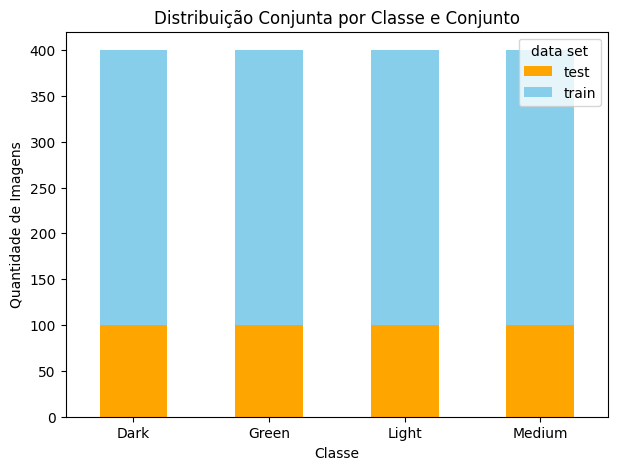

In [71]:
#Distribuição conjunta (stacked bar chart)
cross_counts = pd.crosstab(coffee_info["labels"], coffee_info["data set"])

cross_counts.plot(kind="bar", stacked=True, figsize=(7,5), color=["orange","skyblue"])
plt.title("Distribuição Conjunta por Classe e Conjunto")
plt.ylabel("Quantidade de Imagens")
plt.xlabel("Classe")
plt.xticks(rotation=0)
plt.show()

In [72]:
summary_table = coffee_info.groupby(["labels","data set"]).size().unstack(fill_value=0)
summary_table["Total"] = summary_table.sum(axis=1)
summary_table.loc["Total"] = summary_table.sum()
print(summary_table)

data set  test  train  Total
labels                      
Dark       100    300    400
Green      100    300    400
Light      100    300    400
Medium     100    300    400
Total      400   1200   1600


C:\Users\noise\AppData\Local\Temp\ipykernel_1772\810673631.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=4, random_state=6))


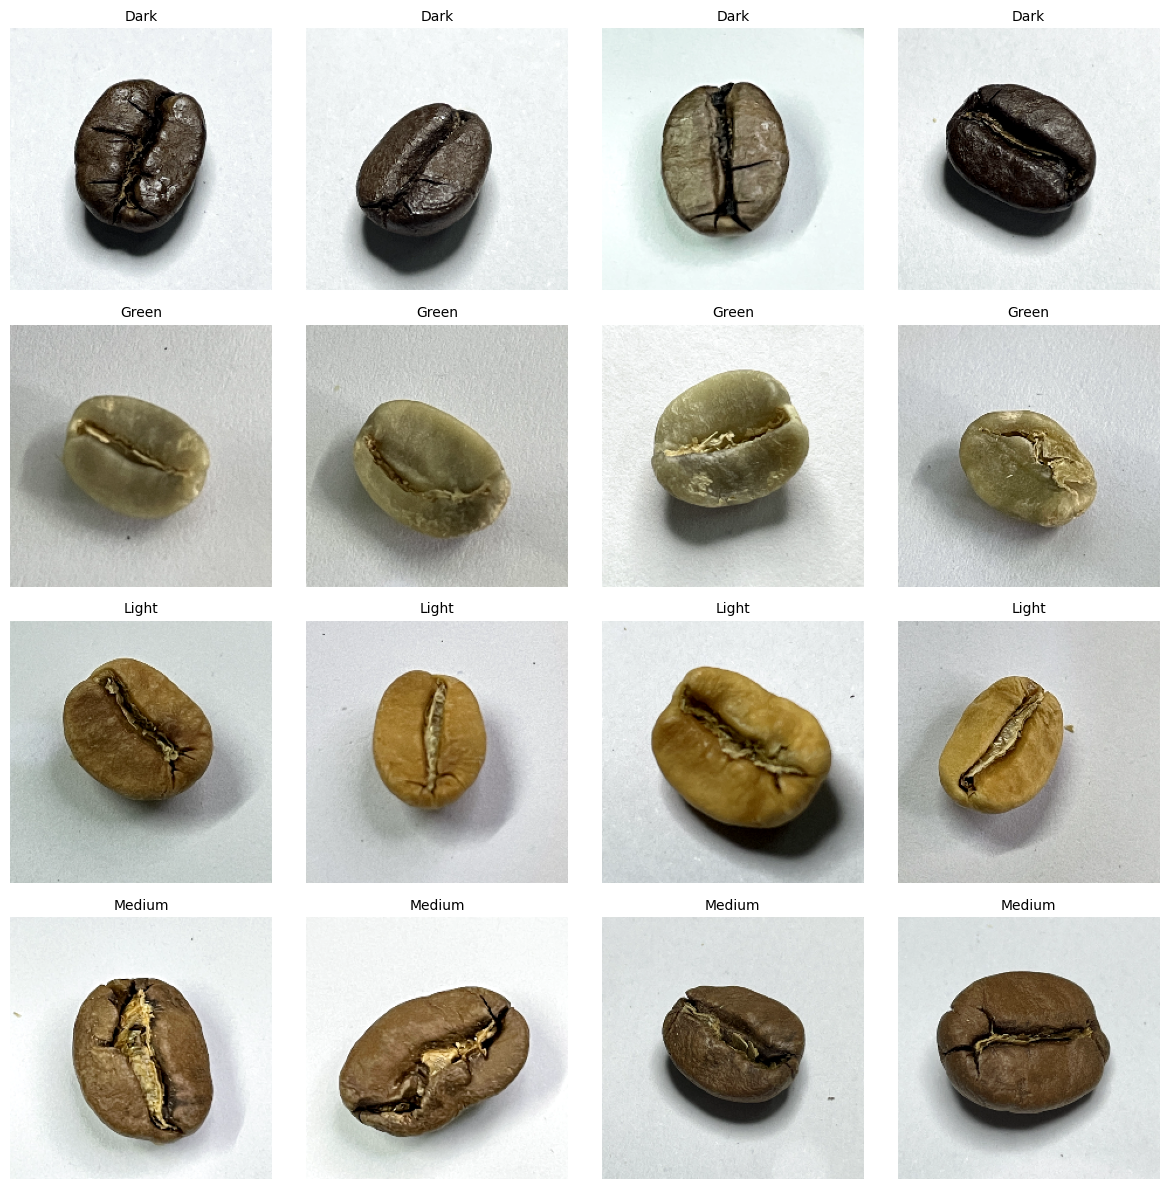

In [73]:
# Exemplos de imagens disponíveis em cada classe

amostras = (
    coffee_info.groupby("labels")
    .apply(lambda x: x.sample(n=4, random_state=6))
    .reset_index(drop=True)
)

x, axes = plt.subplots(4, 4, figsize=(12, 12))

for ax, (_, row) in zip(axes.flatten(), amostras.iterrows()):
    img = Image.open(row['filepaths'])
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(row['labels'], fontsize=10)

plt.tight_layout()
plt.show()

In [74]:
def retorna_info_arquivos(caminho):
    return os.path.getsize(caminho) / 1024  # conversão para KB

coffee_info['tamanho_kb'] = coffee_info['filepaths'].apply(retorna_info_arquivos)
tamanho_medio_arquivos = coffee_info['tamanho_kb'].mean()
maior_imagem = coffee_info["tamanho_kb"].max()
menor_imagem = coffee_info["tamanho_kb"].min()
desvio_tamanho = coffee_info["tamanho_kb"].std()

print(f'Tamanho médio dos arquivos de imagem: {round(tamanho_medio_arquivos, 2)} KB')
print(f'Menor imagem {round(menor_imagem, 2)} KB')
print(f'Maior imagem {round(maior_imagem, 2)} KB')
print(f'Desvio padrão no tamanho das imagem {round(desvio_tamanho, 2)} KB')


Tamanho médio dos arquivos de imagem: 94.68 KB
Menor imagem 77.93 KB
Maior imagem 108.02 KB
Desvio padrão no tamanho das imagem 4.55 KB


In [75]:
def retorna_dimensao_imagem(caminho):
    with Image.open(caminho) as img:
        return img.size  
    
coffee_info['dimensao'] = coffee_info['filepaths'].apply(retorna_dimensao_imagem)    

print(coffee_info['dimensao'].unique())

[(224, 224)]


In [76]:
# conta quantidades de cores para cada foto

def conta_cores(caminho):
    with Image.open(caminho) as img:
        img_array = np.array(img)
        pixels = img_array.reshape(-1, img_array.shape[-1])    
        cores_unicas = len(np.unique(pixels, axis=0))    
    return cores_unicas

coffee_info['num_cores'] = coffee_info['filepaths'].apply(conta_cores)

In [77]:
cores = coffee_info.groupby('labels')['num_cores'].agg(
    media='mean',
    maximo='max',
    minimo='min',
    desvio_padrao='std'
).reset_index()

print(cores)

   labels       media  maximo  minimo  desvio_padrao
0    Dark   7231.0650   10852    4570    1346.425399
1   Green   8048.0425   12444    4640    1398.438248
2   Light  10046.6975   15723    6195    1679.304691
3  Medium   8548.0475   13785    5560    1392.412618


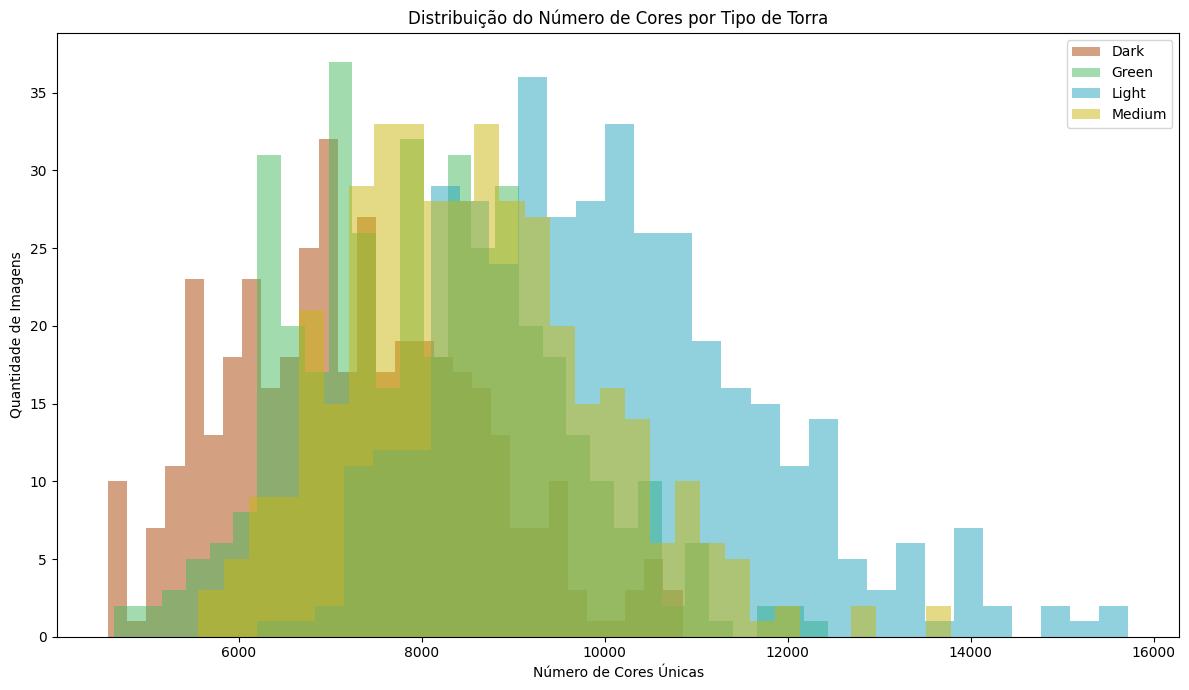

In [78]:
# Apresenta diferença na diversidade de cores em cada foto para cada tipo de torra

plt.figure(figsize=(12,7))
cores = ["#AA4307", "#47B85F", "#22A5BD", "#CAB70E"]
labels = coffee_info['labels'].unique()

for cor, label in zip(cores, labels):
    dados = coffee_info[coffee_info['labels'] == label]['num_cores']
    plt.hist(dados, bins=30, alpha=0.5, color=cor, label=label)

plt.title('Distribuição do Número de Cores por Tipo de Torra')
plt.xlabel('Número de Cores Únicas')
plt.ylabel('Quantidade de Imagens')
plt.legend()
plt.tight_layout()
plt.show()

## Tratamento das imagens e criação de modelo de machinelearning

In [79]:
# carrega imagem com opção de redução de numero de cores 
def carrega_imagem(caminho, n_colors):
    img = Image.open(caminho)
    img = img.resize((224, 224))
    
    if n_colors > 0:
        # Converte para modo P (paleta) com número específico de cores
        img_quantizada = img.quantize(colors=n_colors, method=2)
        # Converte de volta para RGB
        img_rgb = img_quantizada.convert('RGB')    
        # Normaliza os valores
        img_array = np.array(img_rgb) / 255.0
        return img_array
    else:
        return np.array(img) / 255.0

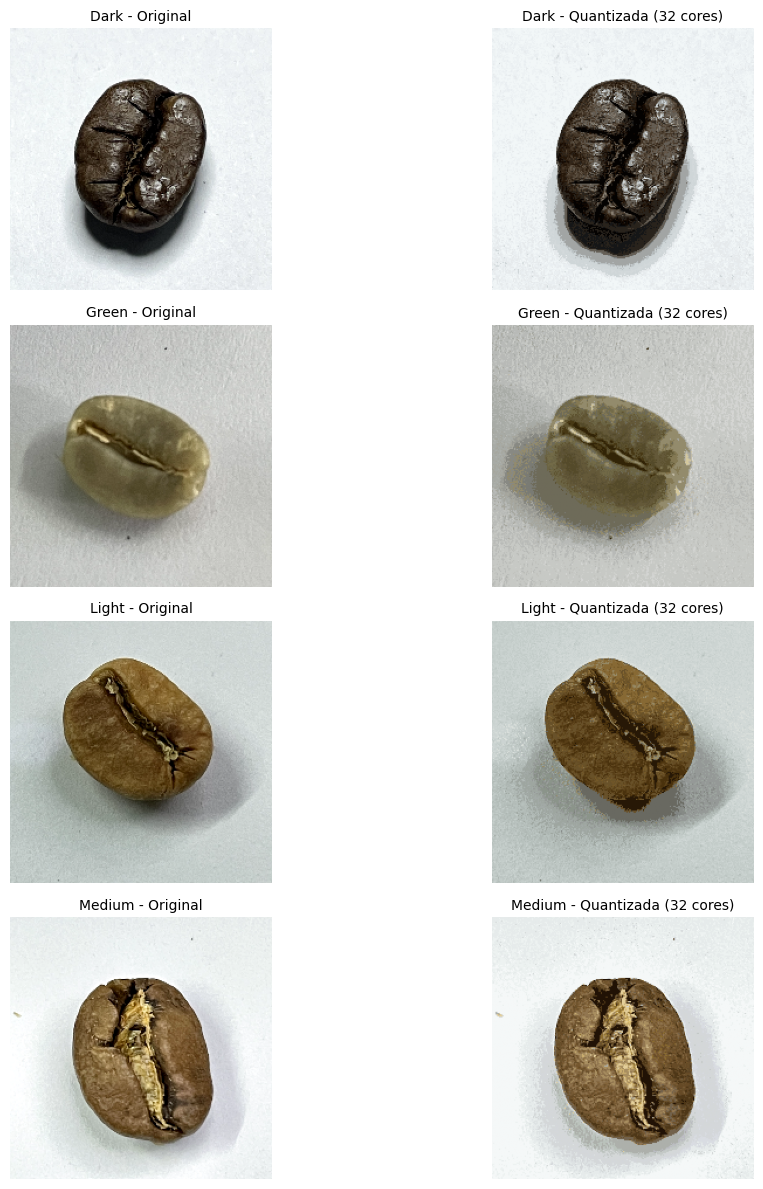

In [80]:
# amostra de imagens com redução de cores
amostras_imagens_convertidas = pd.concat([
    coffee_info[coffee_info['labels'] == label].sample(n=1, random_state=6)
    for label in coffee_info['labels'].unique()
]).reset_index(drop=True)

x, axes = plt.subplots(4, 2, figsize=(12, 12))

for i, (x, row) in enumerate(amostras_imagens_convertidas.iterrows()):
    img_original = Image.open(row['filepaths'])
    axes[i, 0].imshow(img_original)
    axes[i, 0].set_title(f"{row['labels']} - Original", fontsize=10)
    axes[i, 0].axis('off')
    
    img_quantizada = carrega_imagem(row['filepaths'], n_colors=32)
    axes[i, 1].imshow(img_quantizada)
    axes[i, 1].set_title(f"{row['labels']} - Quantizada (32 cores)", fontsize=10)
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [81]:
# Simplificação do dataset, carregando imagens e separação entre dados de treinament oe testes

X = coffee_info['filepaths']
y = coffee_info['labels']

# Separando dados de treinamento e teste em divisões proporcionalmente iguais
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123, stratify=y)

X_train_imgs = np.array([carrega_imagem(fp, 32) for fp in X_train])
X_test_imgs = np.array([carrega_imagem(fp, 32) for fp in X_test])

# setando ordem das classes e criando encoding
ordem_classes = ['green', 'light', 'medium', 'dark']
le = LabelEncoder()
le.fit(ordem_classes)
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

In [ ]:
# criação de modelo Tensorflow. 
# Foi usado no sequencial processos de convolução, redução de dimensionalidade e transformações em vetor. 
model = models.Sequential([
    layers.Input(shape=(224, 224, 3)), # shape = imagem 224x224 pixels, 3 canais (RGB)
    layers.Conv2D(16, (3,3), activation='relu'), 
    layers.MaxPooling2D(),                  
    layers.Conv2D(32, (3,3), activation='relu'), 
    layers.MaxPooling2D(),                 
    layers.Flatten(),                       
    layers.Dense(64, activation='relu'),    
    layers.Dense(len(le.classes_), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Método de Early stop para evitar overfiting
# Caso 5 epochs seguidas não obtiverem melhoras de performace, o aprendizado será finalizando
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

epochs = 10

history = model.fit(X_train_imgs, y_train_enc, epochs=epochs, validation_data=(X_test_imgs, y_test_enc), callbacks=[early_stopping])


Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 161ms/step - accuracy: 0.3545 - loss: 2.1997 - val_accuracy: 0.4604 - val_loss: 0.9485
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.7429 - loss: 0.5768 - val_accuracy: 0.9479 - val_loss: 0.2648
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.9670 - loss: 0.1413 - val_accuracy: 0.9625 - val_loss: 0.1198
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 0.9741 - loss: 0.0840 - val_accuracy: 0.9583 - val_loss: 0.1482
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 0.9848 - loss: 0.0625 - val_accuracy: 0.9833 - val_loss: 0.0524
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.9902 - loss: 0.0300 - val_accuracy: 0.9792 - val_loss: 0.0593
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 0.9875 - loss: 0.0377 - val_accuracy: 0.9667 - val_loss: 0.0831
Epoch 8/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.9911 - loss: 0.0371 - val_accuracy: 0.

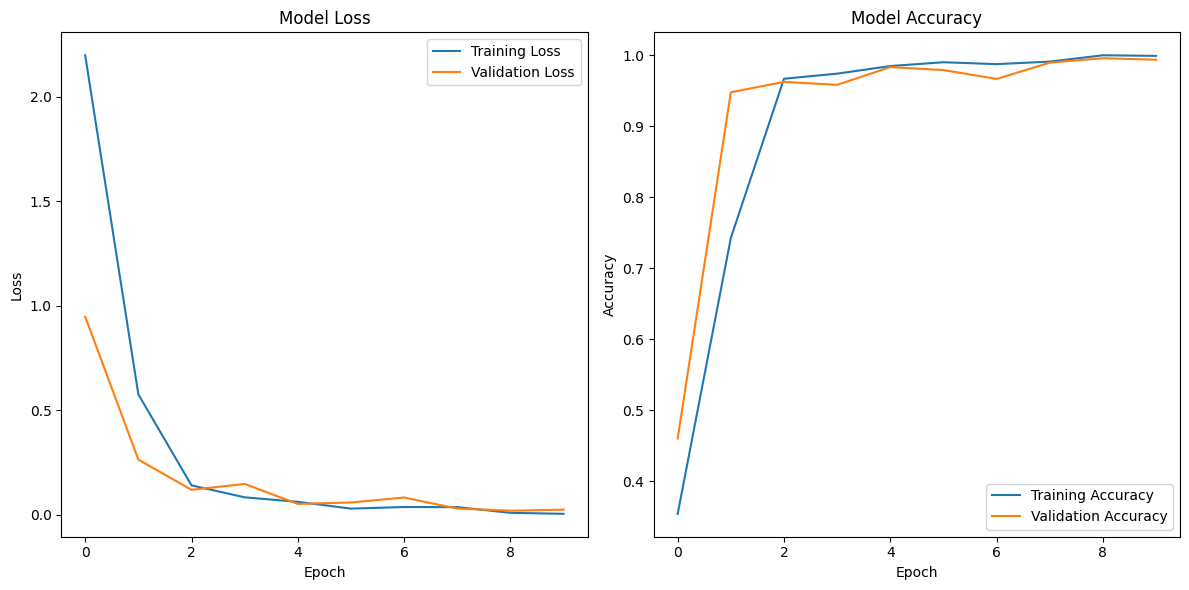

In [105]:
# Curva de aprendizado: 
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [106]:
# Testes de acurácia 
predicao = model.predict(X_test_imgs)
pred_classes = np.argmax(predicao, axis=1)
acuracia = accuracy_score(y_test_enc, pred_classes)

print(f"Acuracia: {acuracia}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
Acuracia: 0.9958333333333333


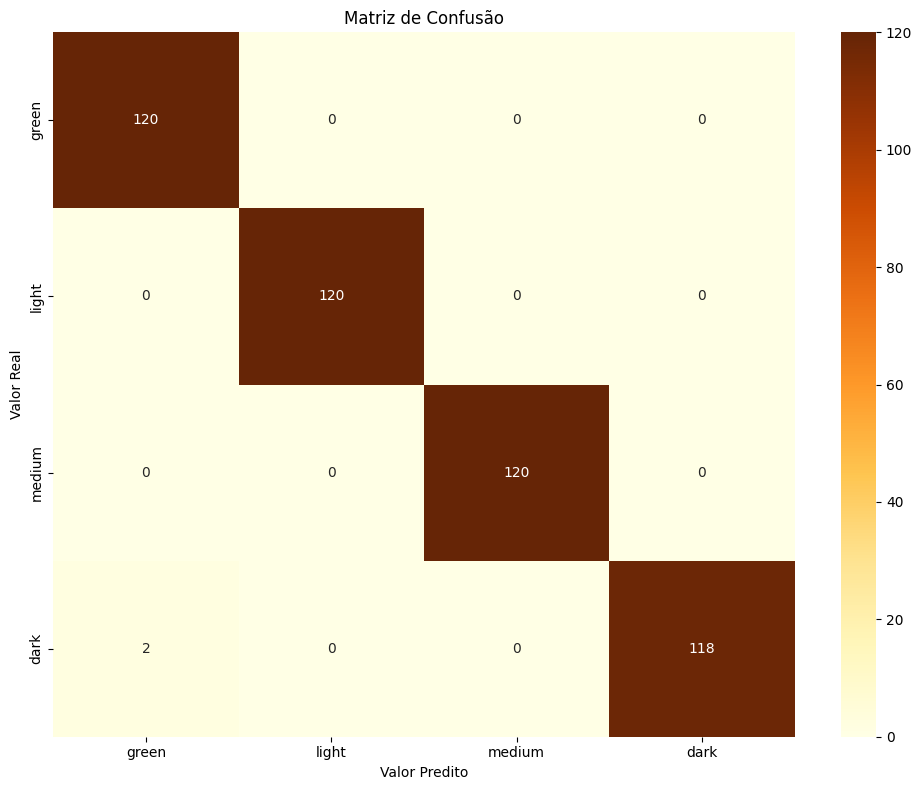


Relatório de Classificação:
              precision    recall  f1-score   support

        Dark       0.98      1.00      0.99       120
       Green       1.00      1.00      1.00       120
       Light       1.00      1.00      1.00       120
      Medium       1.00      0.98      0.99       120

    accuracy                           1.00       480
   macro avg       1.00      1.00      1.00       480
weighted avg       1.00      1.00      1.00       480



In [107]:
# Matriz de confusão:
matriz_confusao = confusion_matrix(y_test_enc, pred_classes)

plt.figure(figsize=(10,8))
sns.heatmap(matriz_confusao, 
            annot=True,
            fmt='d',
            cmap='YlOrBr',  
            xticklabels=ordem_classes,  
            yticklabels=ordem_classes
)

plt.title('Matriz de Confusão')
plt.ylabel('Valor Real')
plt.xlabel('Valor Predito')
plt.tight_layout()
plt.show()

print("\nRelatório de Classificação:")
print(classification_report(y_test_enc, pred_classes, target_names=le.classes_))